# Multiple Author Detection Project

In [124]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.svm import SVC
from nltk.stem.snowball import SnowballStemmer
import matplotlib.pyplot as plt
import time
import json
import os
%matplotlib inline

### Data Aggregation

In [3]:
def DataAggregator(path):
    text_dict = {}
    json_dict = {}
    label_df = pd.DataFrame(columns=['changes', 'positions','file'])

    for file in os.listdir(path):
        if file.endswith('.txt'):
            with open(path+file, 'r', encoding='utf-8') as myfile:
                text_dict[file.replace('problem-', '').replace('.txt', '')] = myfile.read().replace('\n', '')
        else:
            with open(path+file, 'r', encoding='utf-8') as myfile:
                data = json.load(myfile)
                json_dict[file.replace('problem-', '').replace('.truth', '')] = data['changes']

    df = pd.DataFrame(list(text_dict.items()), columns=['file', 'text'])
    label_df = pd.DataFrame(list(json_dict.items()), columns = ['file', 'changes'])

    output_df = df.merge(label_df,on='file')
    output_df = output_df.drop('file', axis = 1)
    return output_df

In [4]:
#Convert the data sets to data frames
test_df = DataAggregator('C:/Users/RSC/PyProjects/Data-Science/Data/pan18-style-change-detection-test-dataset-2018-01-31/')
training_df = DataAggregator('C:/Users/RSC/PyProjects/Data-Science/Data/pan18-style-change-detection-training-dataset-2018-01-31/')
validation_df = DataAggregator('C:/Users/RSC/PyProjects/Data-Science/Data/pan18-style-change-detection-validation-dataset-2018-01-31/')


In [5]:
#Split the data into text and labels
training_labels = training_df['changes']
validation_labels = validation_df['changes']
test_labels = test_df['changes']

training_text = training_df['text']
validation_text = validation_df['text']
test_text = test_df['text']

print("Training Text: " + str(len(training_text)) + ", Training Labels: " + str(len(training_labels)))
print("Test Text: " + str(len(test_text)) + ", Test Labels: " + str(len(test_labels)))
print("Validation Text: " + str(len(validation_text)) + ", Validation Labels: " + str(len(validation_labels)))

Training Text: 2980, Training Labels: 2980
Test Text: 1352, Test Labels: 1352
Validation Text: 1492, Validation Labels: 1492


In [6]:
new_train_text = training_text.append(validation_text)
new_train_labels = training_labels .append(validation_labels)
print("Training Text: " + str(len(new_train_text)) + ", Training Labels: " + str(len(new_train_labels)))

Training Text: 4472, Training Labels: 4472


### Data Preprocessing

In [7]:
#Builds a pipeline
NB_pipeline = Pipeline([('vect', CountVectorizer(strip_accents = 'ascii', ngram_range=(1,5), analyzer='word', stop_words='english')),
                        ('tfidf', TfidfTransformer()),
                        ('clf', BernoulliNB())])

SVC_pipeline = Pipeline([('vect', CountVectorizer(strip_accents = 'ascii', ngram_range=(1,5), analyzer='word', stop_words='english')),
                         ('tfidf', TfidfTransformer()),
                         ('clf', SVC(C=0.5, probability=True))])

KNN_pipeline = Pipeline([('vect', CountVectorizer(strip_accents = 'ascii', ngram_range=(1,5), analyzer='word', stop_words='english')),
                         ('tfidf', TfidfTransformer()),
                         ('clf', KNeighborsClassifier(10))])


### Testing Classifiers

In [8]:
#Train the models and fit to the validation set
start = time.time()
nb_proba = NB_pipeline.fit(new_train_text, new_train_labels).predict_proba(test_text)
nb_prediction = NB_pipeline.predict(test_text)
print("Naive Bayes Accuracy: " + str(metrics.accuracy_score(nb_prediction, test_labels)) + " -- Run time " + str(time.time()-start))
nb_confusion = metrics.confusion_matrix(test_labels, nb_prediction)
print(nb_confusion)


Naive Bayes Accuracy: 0.906804733728 -- Run time 41.165326833724976
[[593  83]
 [ 43 633]]


In [11]:
start = time.time()
svc_proba = SVC_pipeline.fit(new_train_text, new_train_labels).predict_proba(test_text)
svc_prediction = SVC_pipeline.predict(test_text)
print("SVC Accuracy: " + str(metrics.accuracy_score(svc_prediction, test_labels)) + " -- Run time " + str(time.time()-start))
svc_confusion = metrics.confusion_matrix(test_labels, svc_prediction)
print(svc_confusion)

SVC Accuracy: 0.616124260355 -- Run time 737.2877514362335
[[595  81]
 [438 238]]


In [10]:
start = time.time()
knn_proba = KNN_pipeline.fit(new_train_text, new_train_labels).predict_proba(test_text)
knn_prediction = KNN_pipeline.predict(test_text)
print("KNN Accuracy: " + str(metrics.accuracy_score(knn_prediction, test_labels)) + " -- Run time " + str(time.time()-start))
knn_confusion = metrics.confusion_matrix(test_labels, knn_prediction)
print(knn_confusion)

KNN Accuracy: 0.619082840237 -- Run time 43.049291133880615
[[247 429]
 [ 86 590]]


### Results

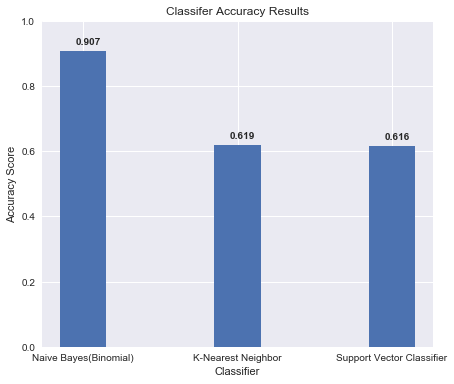

In [119]:
labels = ['Naive Bayes(Binomial)', 'K-Nearest Neighbor', 'Support Vector Classifier']

nb_acc = metrics.accuracy_score(nb_prediction, test_labels)
knn_acc = metrics.accuracy_score(knn_prediction, test_labels)
svc_acc = metrics.accuracy_score(svc_prediction, test_labels)

values = [nb_acc, knn_acc, svc_acc]

fix, ax = plt.subplots(figsize=(7,6))
ax.bar(np.arange(3), height=values, width = 0.3)
ax.set_xticklabels(labels)
ax.set_xticks(np.arange(3))
ax.set_ylabel('Accuracy Score')
ax.set_xlabel('Classifier')
ax.set_ylim(0,1)

for i, v in enumerate(values):
    ax.text(i-.05, v+0.02, '%.3f' % v, fontweight ='bold')

ax.set_title('Classifer Accuracy Results')



In [129]:
columns = ['TN', 'FP', 'FN', 'TP']

confusion = [[nb_confusion[0][0], nb_confusion[0][1], nb_confusion[1][0], nb_confusion[1][1]],
       [knn_confusion[0][0], knn_confusion[0][1], knn_confusion[1][0], knn_confusion[1][1]],
       [svc_confusion[0][0], svc_confusion[0][1], svc_confusion[1][0], svc_confusion[1][1]]]

df = pd.DataFrame(data = confusion, columns = columns, index = labels)

print("Confusion Matrix Summary")
print(df)

Confusion Matrix Summary
                            TN   FP   FN   TP
Naive Bayes(Binomial)      593   83   43  633
K-Nearest Neighbor         247  429   86  590
Support Vector Classifier  595   81  438  238


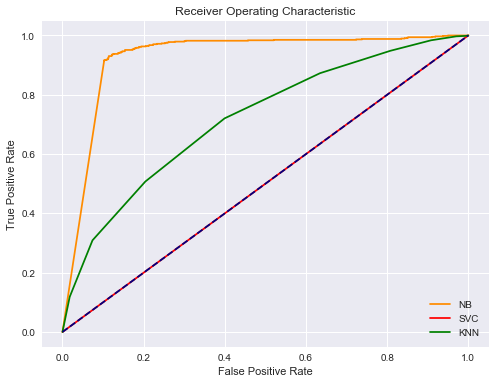

In [96]:
nb_fpr, nb_tpr, __ = metrics.roc_curve(test_labels, nb_proba[:,1])
svc_fpr, svc_tpr, __ = metrics.roc_curve(test_labels, svc_proba[:,1])
knn_fpr, knn_tpr, __ = metrics.roc_curve(test_labels, knn_proba[:,1])

fig, ax = plt.subplots(figsize=(8,6))
ax.set_title("Receiver Operating Characteristic")
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')

ax.plot(nb_fpr, nb_tpr, color='darkorange', label='NB')
plt.plot(svc_fpr, svc_tpr, color = 'red', label='SVC')
plt.plot(knn_fpr, knn_tpr, color = 'green', label = 'KNN')
ax.plot([0,1], [0,1], 'r--', color='navy')

ax.legend(loc="lower right")


plt.show()